In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
import os, sys

In [3]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import Counter

Using TensorFlow backend.


In [4]:
import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

In [5]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
#NUM_SAMPLES = 10000  # Number of samples to train on (only when the data length is very high and we want to train on less)
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100

In [6]:
data = pd.read_json("dolphin_t2_final.json")

In [7]:
data.head()

,Alignment,Equiv,Template,iIndex,lEquations,lSolutions,sQuestion
0,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 18.0...",[],"[m + n = a, m - n = b]",2000989,"[x+y=18.0, x-y=4.0]","[11.0, 7.0]",The sum of two numbers is 18 and their differe...
1,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 22.0...",[],"[m + n = a, m - n = b]",2001344,"[x+y=22.0, x-y=4.0]","[13.0, 9.0]",Two numbers have a sum of 22 . Their differenc...
2,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 34.0...",[],"[m + n = a, m - n = b]",2001019,"[x-y=10.0, x+y=34.0]","[22.0, 12.0]",Two numbers have a difference of 10 and the su...
3,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 38.0...",[],"[m + n = a, m - n = b]",2001024,"[x+y=38.0, x-y=12.0]","[25.0, 13.0]",The sum of two numbers is 38 . Their differenc...
4,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 39.0...",[],"[m + n = a, m - n = b]",2001038,"[x+y=39.0, x-y=7.0]","[23.0, 16.0]",The sum of two numbers is 39 and their differe...


In [8]:
print("num samples:", len(data))

num samples: 831


In [9]:
# Example question
print("Example:")
print("--------")
print("Question: ", data.iloc[110,6])
print("Equation: ", data.iloc[110,4])
print("Solution: ", data.iloc[110,5])

Example:
--------
Question:  find two consecutive even integers whose sum is 126
Equation:  ['x+(x+2.0)=126.0']
Solution:  [62.0]


Question Length

In [10]:
def quest_len(text):
    split_text = text.split()
    return len(split_text)

data["Question_Length"] = data["sQuestion"].apply(quest_len)
data["Question_Length"].head()

0    19
1    19
2    18
3    19
4    18
Name: Question_Length, dtype: int64

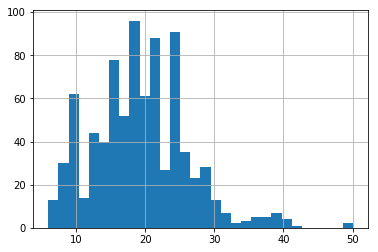

In [11]:
data["Question_Length"].hist(bins=30)
plt.show()

In [12]:
# # determine maximum length input sequence
# max_len_input = max(len(s) for s in input_sequences)
# max_len_input

In [13]:
# I am not taking maximun, to avoid wasted calsulation (knowing that any question beyond 33 will get false prediction)
max_len_input = 33

Now we need to store the input (questions), the target (equations with EOS) and the target input (equations with SOS)

In [14]:
# Here we store the questions
input_texts = list(data["sQuestion"])
input_texts[:3]

['The sum of two numbers is 18 and their difference is 4 . What are the two numbers ?',
 'Two numbers have a sum of 22 . Their difference is 4 . what are the two numbers ?',
 'Two numbers have a difference of 10 and the sum of 34 . What are the numbers ?']

In [15]:
data["lEquations_sos"]  = '<sos> ' + data["lEquations"].astype(str)
data["lEquations_sos"].head()

0     <sos> ['x+y=18.0', 'x-y=4.0']
1     <sos> ['x+y=22.0', 'x-y=4.0']
2    <sos> ['x-y=10.0', 'x+y=34.0']
3    <sos> ['x+y=38.0', 'x-y=12.0']
4     <sos> ['x+y=39.0', 'x-y=7.0']
Name: lEquations_sos, dtype: object

In [16]:
data["lEquations_eos"]  = data["lEquations"].astype(str) + " <eos>"
data["lEquations_eos"].head()

0     ['x+y=18.0', 'x-y=4.0'] <eos>
1     ['x+y=22.0', 'x-y=4.0'] <eos>
2    ['x-y=10.0', 'x+y=34.0'] <eos>
3    ['x+y=38.0', 'x-y=12.0'] <eos>
4     ['x+y=39.0', 'x-y=7.0'] <eos>
Name: lEquations_eos, dtype: object

In [17]:
target_texts = list(data["lEquations_eos"]) # sentence in target language
target_texts_inputs = list(data["lEquations_sos"]) # sentence in target language offset by 1

In [18]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [19]:
# Examining the input sequences
input_sequences[:5]

[[1, 6, 3, 10, 12, 2, 89, 15, 47, 39, 2, 36, 14, 25, 1, 10, 12],
 [10, 12, 63, 23, 6, 3, 119, 47, 39, 2, 36, 14, 25, 1, 10, 12],
 [10, 12, 63, 23, 39, 3, 58, 15, 1, 6, 3, 120, 14, 25, 1, 12],
 [1, 6, 3, 10, 12, 2, 143, 47, 39, 2, 59, 14, 25, 1, 10, 12],
 [1, 6, 3, 10, 12, 2, 121, 15, 47, 39, 2, 54, 14, 25, 1, 12]]

Each **input** word receives a designated index. For example '1' is 'the'; '10' is 'two' 

In [20]:
# get the word to index mapping for input language (dictionary of each word and its frequency)
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 542 unique input tokens.


In [21]:
# Examining word_index
word2idx_inputs

{"'re": 254,
 "'s": 186,
 '0': 79,
 '00': 503,
 '000': 237,
 '038': 435,
 '1': 68,
 '10': 58,
 '100': 135,
 '101': 464,
 '105': 217,
 '107': 510,
 '108': 528,
 '109': 327,
 '11': 97,
 '110': 384,
 '111': 223,
 '112': 215,
 '114': 187,
 '116': 518,
 '117': 507,
 '118': 445,
 '119': 280,
 '12': 59,
 '120': 225,
 '122': 408,
 '123': 228,
 '1236': 468,
 '124': 192,
 '126': 265,
 '127': 359,
 '128': 526,
 '129': 337,
 '13': 104,
 '130': 426,
 '133': 334,
 '134': 437,
 '135': 302,
 '137': 200,
 '138': 502,
 '14': 153,
 '140': 537,
 '1405': 330,
 '144': 226,
 '145': 329,
 '1457': 442,
 '147': 418,
 '148': 517,
 '149': 446,
 '15': 80,
 '150': 257,
 '152': 501,
 '1524': 388,
 '153': 322,
 '156': 406,
 '157': 467,
 '16': 91,
 '162': 541,
 '164': 268,
 '16666666': 458,
 '168': 540,
 '17': 115,
 '171': 271,
 '174': 319,
 '176': 266,
 '18': 89,
 '182': 465,
 '185': 293,
 '186': 240,
 '188': 450,
 '19': 208,
 '192': 282,
 '194': 423,
 '195': 443,
 '199': 377,
 '1st': 233,
 '2': 43,
 '20': 83,
 '200'

In [22]:
# # tokenize the outputs
# # don't filter out special characters
# # otherwise <sos> and <eos> won't appear
# tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='[]')
# tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
# target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
# target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [23]:
# # Examining the target sequences
# target_sequences_inputs[:10]

In [24]:
# tokenizer_outputs.word_index

In [25]:
from nltk import wordpunct_tokenize

In [26]:
# !!! Currently takes as input only the train_data for the vocabulary!!!
def create_counter(clean_df):
    """
    The purpose of this function is to crate a word counter for a corpus for 1. adjust the desired vocabulary size (see 
    vocab_coverage function), 2. to create a word index for padding (see create_word_index function)
    input:
    - clean_df: a pandas dataframe with a column of clean text (after initial preprocessing)
    The function returns:
    - lexicon: a list of all the tokens in the corpus
    - word_count: a dictionary with all the tokens and their frequency
    """
    
    # First create the full lexicon (all the words/symbols form the new_text colomn)
    lexicon = []
    for sent in clean_df["lEquations_eos"].values:
        token = wordpunct_tokenize(sent) # Tokenizes each sentence
        lexicon += token # and adds it to the lexicon
    print("Full lexicon length: {}.".format(len(lexicon)))
    # Create a Counter object, which is a dictionary of all the words in the lexicon, and their frequency
    word_counts = Counter(lexicon) 
    print("Counter (unique words) length: {}.".format(len(word_counts)))
    # I need to return both the lexicon and the word_count, since I use then for reducing the vocabulary
    return lexicon, word_counts

In [27]:
# Creating the lexicon and the counter
lexicon, word_counter = create_counter(data)

Full lexicon length: 22856.
Counter (unique words) length: 276.


In [28]:
def create_word_index(lb, ub, counter):
    """
    The function creates a word index, where each token is designated with an index. This is used for encoding.
    input:
    - lb: lower bound, the minimum number that a word appears in the original korpus
    - ub: upper bound, the maximum number that a word appears in the original korpus
    - counter: a Counter object that contains the frequency of each word 
    The function returns a dictionary with the words as keys and the index as values 
    """
    
    lexicon_2 = [w for w in counter if ub >= counter[w] >= lb]
    print("New lexicon length: {}.".format(len(lexicon_2)))
    word_index = {}
    counter = 1
    for word in lexicon_2:
        word_index[word] = counter
        counter += 1
    return word_index

In [29]:
nltk_word_index = create_word_index(0, 5000, word_counter)

New lexicon length: 276.


In [30]:
nltk_word_index

{"'": 10,
 "'(": 168,
 "',": 9,
 "']": 13,
 '(': 218,
 '(-': 86,
 ')': 217,
 ")',": 36,
 ")']": 87,
 ')*': 144,
 ')*(': 268,
 ')+': 70,
 ')+(': 69,
 ')-': 73,
 ')=': 72,
 ')=(': 68,
 ')=-': 74,
 '*': 66,
 '*(': 65,
 '+': 3,
 '+(': 105,
 '+(-': 34,
 '-': 11,
 '.': 7,
 '0': 8,
 '01': 193,
 '038': 209,
 '08': 250,
 '1': 52,
 '10': 18,
 '100': 96,
 '1000': 182,
 '101': 230,
 '105': 104,
 '107': 257,
 '108': 271,
 '109': 28,
 '11': 37,
 '110': 167,
 '111': 128,
 '112': 94,
 '114': 127,
 '116': 264,
 '117': 254,
 '118': 219,
 '119': 159,
 '12': 21,
 '120': 132,
 '122': 189,
 '123': 146,
 '1236': 233,
 '124': 153,
 '126': 113,
 '127': 118,
 '128': 269,
 '129': 92,
 '13': 32,
 '130': 201,
 '133': 89,
 '134': 211,
 '135': 227,
 '137': 202,
 '138': 246,
 '14': 97,
 '140': 273,
 '1405': 60,
 '144': 134,
 '145': 53,
 '1457': 215,
 '147': 195,
 '148': 263,
 '149': 220,
 '15': 83,
 '150': 90,
 '152': 247,
 '1524': 171,
 '153': 258,
 '156': 187,
 '157': 232,
 '16': 48,
 '164': 117,
 '16666666': 229,


In [31]:
# I define this variable since I will need it later for the model
nltk_vocab_size = len(nltk_word_index)

In [32]:
def preprocess_with_nltk(column, word_index):
    """
    The function turns a text into padded arrays, ready as an input for the model
    input:
    - df: a pandas dataframe
    - max_len: the length of the array for padding the comments
    - encoding_support: needs to receive 'word_index'. The purpose of this argument is to allow using this function when creating
      the datasets for the model.
    The function return a matrix with the padded arrays
    """
        
    X_text = column.values
    X_encode_list = []
    max_len = 0 # Capture the max len of the sentences (equations)
    for sent in X_text:
        tokenized = wordpunct_tokenize(sent)
        encoded = np.array([word_index[word] for word in tokenized if word in word_index])
        X_encode_list.append(encoded)
        length = len(encoded)
        if length > max_len:
            max_len = length
    X_pad = pad_sequences(X_encode_list, maxlen=max_len, padding='post')
        
    return X_pad

In [33]:
decoder_targets = preprocess_with_nltk(data["lEquations_eos"], nltk_word_index)

In [34]:
decoder_inputs = preprocess_with_nltk(data["lEquations_sos"], nltk_word_index)

Shapes should be the same

In [35]:
decoder_inputs.shape

(831, 57)

In [36]:
decoder_targets[100]

array([  1,   2, 105,   2,   3,  52,   7,   8,  72,  33,   7,   8,  13,
        14,  15,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0])

Each **target** word receives a designated index.

In [37]:
# # get the word to index mapping for output language
# word2idx_outputs = tokenizer_outputs.word_index
# print('Found %s unique output tokens.' % len(word2idx_outputs))

In [38]:
# # Examining word_index. This tokenuzer relates to both 'target' and 'target_inputs' (that's why it includes both <eos> and <sos>
# word2idx_outputs

In [39]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(nltk_word_index) + 1

In [40]:
num_words_output

277

This is the size of the one-hot matrix (times the input length 57) as the output of the model

The max_len_target may be larger than this one if the data is really small, so I may consider enlarge it manually.

In [41]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[1])
print()
# I commented the following line due to use of NLTK
#decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[1])
print("decoder_inputs.shape:", decoder_inputs.shape)
print()
# I commented the following line due to use of NLTK
#decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("decoder_targets[0]:", decoder_targets[1])
print("decoder_targets.shape:", decoder_targets.shape)

encoder_inputs.shape: (831, 33)
encoder_inputs[0]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  10
  12  63  23   6   3 119  47  39   2  36  14  25   1  10  12]

decoder_inputs[0]: [14 16  1  2  3  4  5 17  7  8  9 10  2 11  4  5 12  7  8 13  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]
decoder_inputs.shape: (831, 57)

decoder_targets[0]: [ 1  2  3  4  5 17  7  8  9 10  2 11  4  5 12  7  8 13 14 15 16  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
decoder_targets.shape: (831, 58)


In [42]:
# I am taking out the 19th element in the decoder input, '15' to make the shape the same
decoder_targets = decoder_targets[: , np.r_[0:19, 20:58]]

In [43]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in decoder_targets)
max_len_target

57

In [44]:
# # store all the pre-trained word vectors
# print('Loading word vectors...')
# word2vec = {}
# with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
#   # is just a space-separated text file in the format:
#   # word vec[0] vec[1] vec[2] ...
#   for line in f:
#     values = line.split()
#     word = values[0]
#     vec = np.asarray(values[1:], dtype='float32')
#     word2vec[word] = vec
# print('Found %s word vectors.' % len(word2vec))




# # prepare embedding matrix
# print('Filling pre-trained embeddings...')
# num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
# embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
# for word, i in word2idx_inputs.items():
#   if i < MAX_NUM_WORDS:
#     embedding_vector = word2vec.get(word)
#     if embedding_vector is not None:
#       # words not found in embedding index will be all zeros.
#       embedding_matrix[i] = embedding_vector

In [45]:
# This is instead of the row in the embedding matrix. If I use pre-trained I don't need this line
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

For now I am not using a pre-trained

In [46]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  #weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [47]:
len(input_texts)

831

In [48]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output #########################################
  ),
  dtype='float32'
)

In [49]:
# Remind myself what decoder_targets is
decoder_targets

array([[  1,   2,   3, ...,   0,   0,   0],
       [  1,   2,   3, ...,   0,   0,   0],
       [  1,   2,  11, ...,   0,   0,   0],
       ..., 
       [  1, 245,   5, ...,  16,   0,   0],
       [  1,  23,   7, ...,   0,   0,   0],
       [  1,   2,   3, ...,   0,   0,   0]])

In [50]:
# assign the values. So the one hot has three dimensions: the first is the 10000 data rows, the second is the 7 words of the 
# target, and the third is the 'num_word_output' which is the number of unique words in the target. So the 'word' varaible is the
# value in the 'decoder_targets', for example 147, so this will be the index in the third dimension of the one_hot
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [51]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))

embed_encod = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True, # Because I use return_state=True I can have h and c, otherwise I would get only the encoder outputs
  dropout=0.3 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(embed_encod)
# encoder_outputs, h = encoder(embed_encod) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,)) # Important. I am using the max_len of the target(!) here

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  dropout=0.3 # dropout not available on gpu
)
# Below - like the encoder receives an input of 'embed_encode', here are two inputs: 1. the target text, represented by 
# decoder_input_x, 2. the the encoder_state (h,c) from the encoder
# Also, I don't need the h and c as outputs (as I willl need them in the prediction)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [52]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [53]:
# Compile the model
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 57)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 100)      54300       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 57, 256)      70912       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [55]:
# Train the model
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
  verbose=1,
)

Train on 664 samples, validate on 167 samples
Epoch 1/100
664/664 [==============================] - ETA: 15s - loss: 5.6308 - acc: 0.00 - ETA: 8s - loss: 5.5939 - acc: 0.2762 - ETA: 5s - loss: 5.5532 - acc: 0.380 - ETA: 4s - loss: 5.5078 - acc: 0.426 - ETA: 3s - loss: 5.4487 - acc: 0.449 - ETA: 2s - loss: 5.3559 - acc: 0.462 - ETA: 1s - loss: 5.1963 - acc: 0.473 - ETA: 1s - loss: 4.9516 - acc: 0.484 - ETA: 0s - loss: 4.6769 - acc: 0.495 - ETA: 0s - loss: 4.5057 - acc: 0.500 - 5s 8ms/step - loss: 4.4626 - acc: 0.5009 - val_loss: 3.0143 - val_acc: 0.5367
Epoch 2/100
664/664 [==============================] - ETA: 3s - loss: 2.9166 - acc: 0.550 - ETA: 2s - loss: 2.8751 - acc: 0.546 - ETA: 2s - loss: 2.7635 - acc: 0.553 - ETA: 2s - loss: 2.7366 - acc: 0.547 - ETA: 1s - loss: 2.6890 - acc: 0.546 - ETA: 1s - loss: 2.6523 - acc: 0.546 - ETA: 1s - loss: 2.6071 - acc: 0.549 - ETA: 0s - loss: 2.5771 - acc: 0.550 - ETA: 0s - loss: 2.5585 - acc: 0.548 - ETA: 0s - loss: 2.5367 - acc: 0.548 - 4s 6m

Epoch 17/100
664/664 [==============================] - ETA: 4s - loss: 0.9370 - acc: 0.769 - ETA: 3s - loss: 0.9297 - acc: 0.767 - ETA: 3s - loss: 0.9153 - acc: 0.769 - ETA: 2s - loss: 0.9073 - acc: 0.770 - ETA: 2s - loss: 0.9074 - acc: 0.771 - ETA: 1s - loss: 0.9042 - acc: 0.771 - ETA: 1s - loss: 0.9060 - acc: 0.770 - ETA: 1s - loss: 0.9028 - acc: 0.770 - ETA: 0s - loss: 0.9010 - acc: 0.771 - ETA: 0s - loss: 0.9004 - acc: 0.771 - 5s 7ms/step - loss: 0.8981 - acc: 0.7726 - val_loss: 1.0121 - val_acc: 0.7530
Epoch 18/100
664/664 [==============================] - ETA: 3s - loss: 0.8394 - acc: 0.785 - ETA: 3s - loss: 0.8464 - acc: 0.788 - ETA: 2s - loss: 0.8645 - acc: 0.783 - ETA: 2s - loss: 0.8557 - acc: 0.784 - ETA: 2s - loss: 0.8640 - acc: 0.783 - ETA: 1s - loss: 0.8597 - acc: 0.784 - ETA: 1s - loss: 0.8544 - acc: 0.785 - ETA: 1s - loss: 0.8585 - acc: 0.784 - ETA: 0s - loss: 0.8606 - acc: 0.783 - ETA: 0s - loss: 0.8549 - acc: 0.784 - 5s 7ms/step - loss: 0.8555 - acc: 0.7846 - val_los

Epoch 33/100
664/664 [==============================] - ETA: 3s - loss: 0.5081 - acc: 0.866 - ETA: 3s - loss: 0.4730 - acc: 0.875 - ETA: 3s - loss: 0.4659 - acc: 0.879 - ETA: 2s - loss: 0.4828 - acc: 0.874 - ETA: 2s - loss: 0.4863 - acc: 0.875 - ETA: 1s - loss: 0.4927 - acc: 0.873 - ETA: 1s - loss: 0.4946 - acc: 0.873 - ETA: 1s - loss: 0.4978 - acc: 0.872 - ETA: 0s - loss: 0.4969 - acc: 0.873 - ETA: 0s - loss: 0.4938 - acc: 0.874 - 5s 7ms/step - loss: 0.4946 - acc: 0.8738 - val_loss: 0.6528 - val_acc: 0.8459
Epoch 34/100
664/664 [==============================] - ETA: 3s - loss: 0.5082 - acc: 0.875 - ETA: 3s - loss: 0.4730 - acc: 0.882 - ETA: 3s - loss: 0.4848 - acc: 0.876 - ETA: 2s - loss: 0.4825 - acc: 0.877 - ETA: 2s - loss: 0.4776 - acc: 0.878 - ETA: 1s - loss: 0.4799 - acc: 0.878 - ETA: 1s - loss: 0.4804 - acc: 0.878 - ETA: 1s - loss: 0.4857 - acc: 0.876 - ETA: 0s - loss: 0.4854 - acc: 0.876 - ETA: 0s - loss: 0.4815 - acc: 0.877 - 5s 7ms/step - loss: 0.4798 - acc: 0.8777 - val_los

Epoch 49/100
664/664 [==============================] - ETA: 3s - loss: 0.3631 - acc: 0.899 - ETA: 3s - loss: 0.3635 - acc: 0.902 - ETA: 3s - loss: 0.3599 - acc: 0.904 - ETA: 2s - loss: 0.3694 - acc: 0.902 - ETA: 2s - loss: 0.3720 - acc: 0.901 - ETA: 1s - loss: 0.3682 - acc: 0.902 - ETA: 1s - loss: 0.3664 - acc: 0.903 - ETA: 0s - loss: 0.3667 - acc: 0.903 - ETA: 0s - loss: 0.3685 - acc: 0.902 - ETA: 0s - loss: 0.3690 - acc: 0.901 - 5s 7ms/step - loss: 0.3719 - acc: 0.9013 - val_loss: 0.5756 - val_acc: 0.8619
Epoch 50/100
664/664 [==============================] - ETA: 3s - loss: 0.3465 - acc: 0.909 - ETA: 3s - loss: 0.3558 - acc: 0.905 - ETA: 3s - loss: 0.3508 - acc: 0.906 - ETA: 2s - loss: 0.3607 - acc: 0.903 - ETA: 2s - loss: 0.3575 - acc: 0.904 - ETA: 1s - loss: 0.3602 - acc: 0.904 - ETA: 1s - loss: 0.3584 - acc: 0.904 - ETA: 0s - loss: 0.3628 - acc: 0.903 - ETA: 0s - loss: 0.3674 - acc: 0.902 - ETA: 0s - loss: 0.3667 - acc: 0.901 - 5s 7ms/step - loss: 0.3668 - acc: 0.9014 - val_los

Epoch 65/100
664/664 [==============================] - ETA: 4s - loss: 0.3240 - acc: 0.908 - ETA: 3s - loss: 0.3174 - acc: 0.910 - ETA: 3s - loss: 0.3138 - acc: 0.912 - ETA: 2s - loss: 0.3087 - acc: 0.913 - ETA: 2s - loss: 0.3045 - acc: 0.913 - ETA: 1s - loss: 0.3038 - acc: 0.914 - ETA: 1s - loss: 0.3022 - acc: 0.915 - ETA: 1s - loss: 0.3019 - acc: 0.915 - ETA: 0s - loss: 0.3014 - acc: 0.915 - ETA: 0s - loss: 0.2995 - acc: 0.916 - 5s 8ms/step - loss: 0.2982 - acc: 0.9166 - val_loss: 0.5621 - val_acc: 0.8694
Epoch 66/100
664/664 [==============================] - ETA: 3s - loss: 0.3157 - acc: 0.915 - ETA: 3s - loss: 0.2970 - acc: 0.917 - ETA: 3s - loss: 0.2922 - acc: 0.919 - ETA: 2s - loss: 0.2981 - acc: 0.918 - ETA: 2s - loss: 0.3002 - acc: 0.917 - ETA: 1s - loss: 0.3019 - acc: 0.916 - ETA: 1s - loss: 0.3035 - acc: 0.915 - ETA: 1s - loss: 0.2992 - acc: 0.917 - ETA: 0s - loss: 0.2982 - acc: 0.917 - ETA: 0s - loss: 0.2960 - acc: 0.918 - 5s 8ms/step - loss: 0.2943 - acc: 0.9182 - val_los

Epoch 81/100
664/664 [==============================] - ETA: 4s - loss: 0.2461 - acc: 0.930 - ETA: 3s - loss: 0.2459 - acc: 0.930 - ETA: 3s - loss: 0.2327 - acc: 0.934 - ETA: 2s - loss: 0.2384 - acc: 0.932 - ETA: 2s - loss: 0.2410 - acc: 0.932 - ETA: 1s - loss: 0.2362 - acc: 0.933 - ETA: 1s - loss: 0.2398 - acc: 0.932 - ETA: 1s - loss: 0.2371 - acc: 0.933 - ETA: 0s - loss: 0.2357 - acc: 0.934 - ETA: 0s - loss: 0.2398 - acc: 0.932 - 5s 8ms/step - loss: 0.2419 - acc: 0.9324 - val_loss: 0.5509 - val_acc: 0.8731
Epoch 82/100
664/664 [==============================] - ETA: 4s - loss: 0.2622 - acc: 0.924 - ETA: 3s - loss: 0.2512 - acc: 0.930 - ETA: 3s - loss: 0.2475 - acc: 0.931 - ETA: 2s - loss: 0.2417 - acc: 0.931 - ETA: 2s - loss: 0.2489 - acc: 0.929 - ETA: 1s - loss: 0.2453 - acc: 0.930 - ETA: 1s - loss: 0.2436 - acc: 0.931 - ETA: 1s - loss: 0.2439 - acc: 0.931 - ETA: 0s - loss: 0.2413 - acc: 0.932 - ETA: 0s - loss: 0.2409 - acc: 0.932 - 5s 8ms/step - loss: 0.2403 - acc: 0.9323 - val_los

Epoch 97/100
664/664 [==============================] - ETA: 3s - loss: 0.1890 - acc: 0.946 - ETA: 3s - loss: 0.1936 - acc: 0.944 - ETA: 3s - loss: 0.1902 - acc: 0.945 - ETA: 2s - loss: 0.1907 - acc: 0.944 - ETA: 2s - loss: 0.1950 - acc: 0.944 - ETA: 1s - loss: 0.1928 - acc: 0.944 - ETA: 1s - loss: 0.1915 - acc: 0.945 - ETA: 1s - loss: 0.1896 - acc: 0.945 - ETA: 0s - loss: 0.1933 - acc: 0.944 - ETA: 0s - loss: 0.1968 - acc: 0.943 - 5s 7ms/step - loss: 0.1973 - acc: 0.9431 - val_loss: 0.5525 - val_acc: 0.8764
Epoch 98/100
664/664 [==============================] - ETA: 3s - loss: 0.2099 - acc: 0.937 - ETA: 3s - loss: 0.2044 - acc: 0.941 - ETA: 3s - loss: 0.1911 - acc: 0.946 - ETA: 2s - loss: 0.1882 - acc: 0.947 - ETA: 2s - loss: 0.1899 - acc: 0.945 - ETA: 1s - loss: 0.1912 - acc: 0.944 - ETA: 1s - loss: 0.1876 - acc: 0.946 - ETA: 1s - loss: 0.1883 - acc: 0.945 - ETA: 0s - loss: 0.1909 - acc: 0.944 - ETA: 0s - loss: 0.1933 - acc: 0.944 - 5s 7ms/step - loss: 0.1937 - acc: 0.9443 - val_los

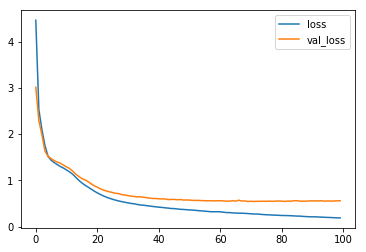

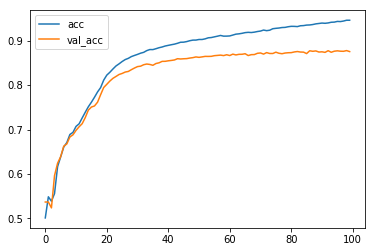

In [56]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
# # Save model
# model.save('...h5')

In [57]:
##### Make predictions #####
# We need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone. It is exactly as the encoder in the training model
# From this we will get our initial decoder hidden state (h,c)
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [58]:
# These inputs are placeholders for the output of the encoder_model above
decoder_state_input_h = Input(shape=(LATENT_DIM,)) 
decoder_state_input_c = Input(shape=(LATENT_DIM,)) 
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

In [59]:
decoder_inputs_single = Input(shape=(1,))
# The single word input (at its time) will be embedded
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [60]:
# this time, we want to keep the states too (h and c of the decoder), to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x, # This is the input of the generated previous word in the prediction
  initial_state=decoder_states_inputs # The h and c states from encoder_model
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru

In [61]:
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

In [62]:
# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states)

In [63]:
# map indexes back into real words
# so we can view the results (it's the opposite, v:k instead k:v)
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in nltk_word_index.items()} # nltk_word_index replaced word2idx_outputs

In [64]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = nltk_word_index['<'] # Instead of <sos> till parsing is better (as input token). First Token

    # if we get this we break
    eos = nltk_word_index['>'] # Instead of <eos> till parsing is better (as input token). Last Token

    # Create the translation - make prediction 7 (or any target length) times, and each time generate token, h, c
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # output_tokens, h = decoder_model.predict([target_seq] + states_value) # gru

        # Get next word
        idx = np.argmax(output_tokens[0, 0, :])

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx

        # Update states
        states_value = [h, c]
        # states_value = [h] # gru

    return ' '.join(output_sentence)

In [66]:
while True:
    # Do some test translations
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    print(input_seq)
    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', input_texts[i])
    print('Translation:', translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   7 43  8 16  4 33  6  2 85]]
-
Input: find 2 consecutive odd integers whose sum is 56
Translation: ['( 2 0 k 1 0 1 + 0 2 0 2 * + . )= . * . - . * . 1 . 1 = 0 ']
Continue? [Y/n]Y
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  6
   3 40  8  4  2 79  7  1  4]]
-
Input: the sum of five consecutive integers is 0 . find the integers ?
Translation: ['( x - . )+ . +( - . * - . )+( . * + )= . )= . < eos 0 eos <
Continue? [Y/n]n


In [67]:
example = ["Two numbers have a difference of 10 and the sum of 34 . What are the numbers ?"]

In [68]:
example_sequences = tokenizer_inputs.texts_to_sequences(example)
print(example_sequences)

[[10, 12, 63, 23, 39, 3, 58, 15, 1, 6, 3, 120, 14, 25, 1, 12]]


In [69]:
example_inputs = pad_sequences(example_sequences, maxlen=max_len_input)
print(example_inputs)
example_translation = decode_sequence(example_inputs)
example_translation

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  10
   12  63  23  39   3  58  15   1   6   3 120  14  25   1  12]]


"[' x y - = 0 . ', x y x y x 5 0 5 0 x y eos < ']"